In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib

from IPython import display

2.4.1


Construct Distiller() class
The custom Distiller() class, overrides the Model methods train_step, test_step, and compile(). In order to use the distiller, we need:

A trained teacher model
A student model to train
A student loss function on the difference between student predictions and ground-truth
A distillation loss function, along with a temperature, on the difference between the soft student predictions and the soft teacher labels
An alpha factor to weight the student and distillation loss
An optimizer for the student and (optional) metrics to evaluate performance
In the train_step method, we perform a forward pass of both the teacher and student, calculate the loss with weighting of the student_loss and distillation_loss by alpha and 1 - alpha, respectively, and perform the backward pass. Note: only the student weights are updated, and therefore we only calculate the gradients for the student weights.

In the test_step method, we evaluate the student model on the provided dataset.

In [2]:

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results
   

In [3]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
use_microfrontend = True

Create student and teacher models
Initialy, we create a teacher model and a smaller student model. Both models are convolutional neural networks and created using Sequential(), but could be any Keras model.

In [5]:
data_dir = pathlib.Path('C:/Users/hpate108/Downloads/project1/my_dataset') #os.path.join(os.getenv("HOME"),
 
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']

print('Commands:', commands)

Commands: ['avocado' 'silence' 'stop' 'unknown']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
     len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 2448
Number of examples per label: 60
Example file tensor: tf.Tensor(b'C:\\Users\\hpate108\\Downloads\\project1\\my_dataset\\stop\\53458368_nohash_0.wav', shape=(), dtype=string)


In [7]:

num_train_files = 2000
num_val_files = 248
num_test_files = num_samples - num_train_files - num_val_files
train_files = filenames[:num_train_files]
val_files = filenames[num_train_files: num_train_files + num_val_files]
test_files = filenames[-num_test_files:]


print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 2000
Validation set size 248
Test set size 200


In [8]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def get_spectrogram(waveform):
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length (16000 samples)
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.int16)
  waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
  equal_length = tf.concat([waveform, zero_padding], 0)
  ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
  spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=40,
                                    window_size=40, window_step=20)
  return spectrogram


   

def wavds2specds(waveform_ds):
  spec_grams = np.zeros((0, 49, 40, 1))
  labels = []
  for wav, label in waveform_ds:
    spectrogram = get_spectrogram(wav)
    # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
    # the microfrontend returns 2D tensors (freq, time), so we need to 
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
    spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
    spec_grams = np.concatenate((spec_grams, spectrogram))
    new_label = label.numpy().decode('utf8')
    new_label_id = np.argmax(new_label == commands)
    labels.append(new_label_id) # for numeric labels
    # labels.append(new_label) # for string labels
  return tf.data.Dataset.from_tensor_slices((spec_grams, labels))  

AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
print(waveform_ds)
train_ds = wavds2specds(waveform_ds)

<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>


In [9]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: stop
Waveform shape: (16000,)
Spectrogram shape: (49, 40)
Audio playback


<ipython-input-10-e1cd5567c8a2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, spectrogram.T)


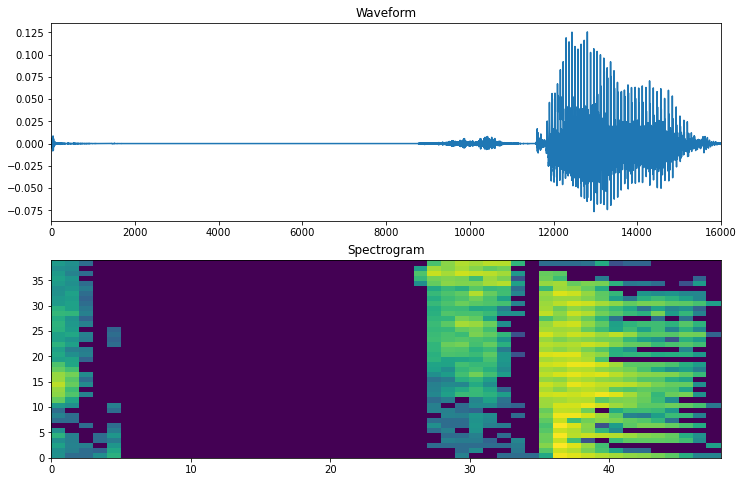

In [10]:
def plot_spectrogram(spectrogram, ax):
  # transpose so that the time is
  # represented in the x-axis (columns).
  freq_bins = spectrogram.shape[1]
  time_dur = spectrogram.shape[0]
  X = np.arange(time_dur)
  Y = range(freq_bins)
  ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [11]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  waveform_ds = files_ds.map(get_waveform_and_label)
  output_ds = wavds2specds(waveform_ds)
  return output_ds

## training set is already builst
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

for spectrogram, _ in train_ds.take(1):
  spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
  input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(commands)


Spectrogram shape (49, 40, 1)
ranges from 0.0 to 709.0
Input shape: (49, 40, 1)


In [12]:
# Create the teacher
teacher = keras.Sequential(
    [
    layers.Input(shape=input_shape),
    #layers.DepthwiseConv2D (3,input_shape=input_shape,padding='same'), 
    layers.Conv2D(64, 3, activation='relu',padding="same"),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, activation='relu',padding="same"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, activation='relu',padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
    ],
    name="teacher",
)


# Create the student
student = keras.Sequential(
    [
    layers.Input(shape=input_shape),
    #layers.DepthwiseConv2D (3,input_shape=input_shape,padding='same'), 
    layers.Conv2D(8, 3, activation='relu',padding="same"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(8, 3, activation='relu',padding="same"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = keras.models.clone_model(student)

#summary
teacher.summary()
student.summary()

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 40, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 20, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 20, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 10, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 10, 256)       2951

In [ ]:
for layer in student.layers:
  #print(layer.name, layer)
   print(student.layers[0].weights)

In [ ]:
print(student.trainable_variables)

In [13]:
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [14]:
EPOCHS = 25
history = teacher.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25
32/32 [==============================] - 10s 303ms/step - loss: 3.6724 - accuracy: 0.5061 - val_loss: 0.8868 - val_accuracy: 0.7258
Epoch 2/25
32/32 [==============================] - 10s 328ms/step - loss: 0.4008 - accuracy: 0.8390 - val_loss: 0.4445 - val_accuracy: 0.8145
Epoch 3/25
32/32 [==============================] - 11s 336ms/step - loss: 0.2517 - accuracy: 0.9002 - val_loss: 0.1499 - val_accuracy: 0.9677
Epoch 4/25
32/32 [==============================] - 11s 336ms/step - loss: 0.2118 - accuracy: 0.9143 - val_loss: 0.1742 - val_accuracy: 0.9516
Epoch 5/25
32/32 [==============================] - 11s 330ms/step - loss: 0.1898 - accuracy: 0.9161 - val_loss: 0.1284 - val_accuracy: 0.9677
Epoch 6/25
32/32 [==============================] - 11s 334ms/step - loss: 0.1646 - accuracy: 0.9332 - val_loss: 0.1508 - val_accuracy: 0.9476
Epoch 7/25
32/32 [==============================] - 11s 328ms/step - loss: 0.1515 - accuracy: 0.9274 - val_loss: 0.1512 - val_accuracy: 0.9637

In [ ]:
print(teacher.trainable_variables)

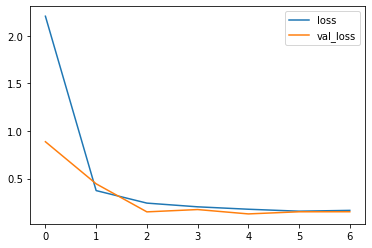

In [15]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## transfer learning
create a base_model from pretrained teacher model excluding the top layer

In [16]:
base_model = Model(inputs=teacher.input, outputs=teacher.layers[6].output)
base_model.summary()
#x = base_model.layers[-1].output 
#print(x)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 40, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 40, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 20, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 20, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 20, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 10, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 10, 128)       512   

In [ ]:
print(base_model.trainable_variables)

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flat_layer = layers.Flatten() 
prediction_layer = tf.keras.layers.Dense(4)
inputs= tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = flat_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 49, 40, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 12, 10, 256)       370432    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 371,460
Trainable params: 371,076
Non-trainable params: 384
_________________________________________________________________


In [18]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [19]:
EPOCHS = 25
history2 = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25
32/32 [==============================] - 8s 223ms/step - loss: 0.7544 - accuracy: 0.6381 - val_loss: 0.2922 - val_accuracy: 0.9073
Epoch 2/25
32/32 [==============================] - 7s 229ms/step - loss: 0.2819 - accuracy: 0.8932 - val_loss: 0.2234 - val_accuracy: 0.9355
Epoch 3/25
32/32 [==============================] - 8s 249ms/step - loss: 0.2172 - accuracy: 0.9137 - val_loss: 0.1982 - val_accuracy: 0.9395
Epoch 4/25
32/32 [==============================] - 8s 246ms/step - loss: 0.1544 - accuracy: 0.9376 - val_loss: 0.1866 - val_accuracy: 0.9395
Epoch 5/25
32/32 [==============================] - 8s 252ms/step - loss: 0.1296 - accuracy: 0.9527 - val_loss: 0.1794 - val_accuracy: 0.9476
Epoch 6/25
32/32 [==============================] - 8s 248ms/step - loss: 0.1114 - accuracy: 0.9582 - val_loss: 0.1967 - val_accuracy: 0.9476
Epoch 7/25
32/32 [==============================] - 8s 252ms/step - loss: 0.0986 - accuracy: 0.9597 - val_loss: 0.2012 - val_accuracy: 0.9395
Epoch 

In [20]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

## test accuracy of teacher

In [21]:
y_pred = np.argmax(teacher.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 87%


## test accuracy of model, after applying transer learning 


In [22]:
y_pred1 = np.argmax(model.predict(test_audio), axis=1)
y_true1 = test_labels

test_acc1 = sum(y_pred1 == y_true1) / len(y_true1)
print(f'Test set accuracy: {test_acc1:.0%}')

Test set accuracy: 92%


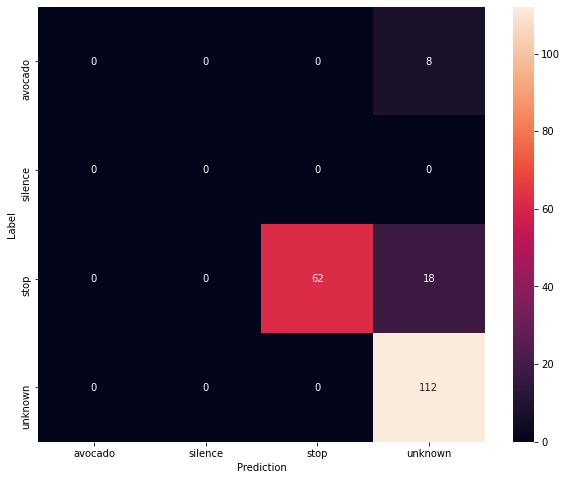

In [23]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

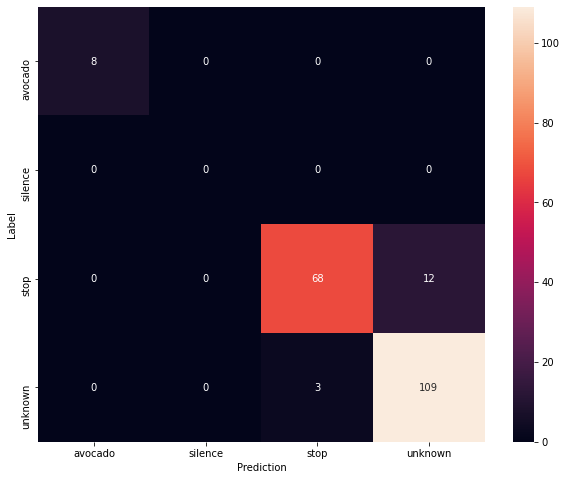

In [24]:
confusion_mtx = tf.math.confusion_matrix(y_true1, y_pred1) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Distill teacher to student

We have already trained the teacher model, and we only need to initialize a
`Distiller(student, teacher)` instance, `compile()` it with the desired losses,
hyperparameters and optimizer, and distill the teacher to the student.

In [25]:
distiller = Distiller(student=student, teacher=model)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

In [33]:
history1=distiller.fit(train_ds, 
    validation_data=val_ds,  
    epochs=3)
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/3
32/32 [==============================] - 3s 81ms/step - sparse_categorical_accuracy: 0.7340 - student_loss: 0.6146 - distillation_loss: 0.0442 - val_sparse_categorical_accuracy: 0.8226 - val_student_loss: 0.2998
Epoch 2/3
32/32 [==============================] - 3s 83ms/step - sparse_categorical_accuracy: 0.7790 - student_loss: 0.5319 - distillation_loss: 0.0403 - val_sparse_categorical_accuracy: 0.9032 - val_student_loss: 0.2151
Epoch 3/3
32/32 [==============================] - 3s 85ms/step - sparse_categorical_accuracy: 0.7990 - student_loss: 0.5026 - distillation_loss: 0.0373 - val_sparse_categorical_accuracy: 0.8911 - val_student_loss: 0.2160


In [34]:
for layer in student.layers:
  #print(layer.name, layer)
   print(student.layers[0].weights)

[<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 1, 8) dtype=float32, numpy=
array([[[[-0.03959629, -0.01335405,  0.03996242, -0.24506944,
          -0.05301792,  0.04799123,  0.20255275, -0.06994757]],

        [[-0.19929987, -0.20582305,  0.2281827 , -0.13920006,
           0.26204613,  0.16704327, -0.06248862, -0.2555499 ]],

        [[-0.15978026,  0.18518692, -0.2818719 ,  0.15034384,
          -0.05003407, -0.066774  ,  0.16654675,  0.20788963]]],


       [[[-0.15951778,  0.02660407, -0.22805353,  0.08348059,
           0.20748313, -0.01912661,  0.28356826, -0.05547734]],

        [[-0.00584696, -0.15670733,  0.19385251, -0.14155853,
          -0.10872767,  0.18781985,  0.18179707, -0.24463019]],

        [[-0.1378518 ,  0.25299406,  0.02879514,  0.11854852,
          -0.05255512,  0.12201206, -0.0376073 , -0.20119385]]],


       [[[ 0.15682246, -0.24433155,  0.08328018, -0.24972552,
           0.18416932, -0.03571261, -0.06829774,  0.00788166]],

        [[-0.17773336,  0.162975

In [ ]:
print(student.trainable_variables)

## compile student from scratch
compile student from scratch and get loss and accuracy to compare 

In [28]:
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [35]:
EPOCHS = 3
history = student_scratch.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/3
32/32 [==============================] - 1s 35ms/step - loss: 0.6316 - accuracy: 0.7420 - val_loss: 0.7599 - val_accuracy: 0.6532
Epoch 2/3
32/32 [==============================] - 1s 34ms/step - loss: 0.5508 - accuracy: 0.7790 - val_loss: 0.5724 - val_accuracy: 0.7621
Epoch 3/3
32/32 [==============================] - 1s 34ms/step - loss: 0.4827 - accuracy: 0.8140 - val_loss: 0.4082 - val_accuracy: 0.8548


In [36]:
y_pred = np.argmax(student_scratch.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 76%


## compare accuracy and loss

In [37]:
student_scratch.evaluate(test_audio, test_labels)

7/7 [==============================] - 0s 5ms/step - loss: 0.4741 - accuracy: 0.7600


[0.4741148352622986, 0.7599999904632568]

In [38]:
distiller.evaluate(test_audio, test_labels)

7/7 [==============================] - 0s 5ms/step - sparse_categorical_accuracy: 0.8600 - student_loss: 0.3482


[0.8600000143051147, 0.31323760747909546]

## Quantize and Convert to TFLite

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(student)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [40]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [41]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [42]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\hpate108\AppData\Local\Temp\1\tmpwplp1m1k\assets


In [43]:
fname = 'final_project2.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 9912 / 9912 bytes to tflite file


In [44]:
!cd

C:\Users\hpate108
